In [2]:
%matplotlib inline

In [3]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.interpolate import interp1d
from scipy.optimize import brentq
from scipy.integrate import quad
from scipy.optimize import brentq

from matplotlib import rc
rc('font', size=20)

In [4]:
# Newtons constant
G_N = 4.302e-3 #(km/s)^2 pc/Msun

#### 'Smearing out' an eccentric orbit

(See e.g. https://www.lehman.edu/faculty/anchordoqui/chapter25.pdf)

$$\frac{\mathrm{d} r}{\mathrm{d} t}=\sqrt{\frac{2}{\mu}}\left(E-\frac{1}{2} \frac{L^{2}}{\mu r^{2}}+\frac{G m_{1} m_{2}}{r}\right)^{\frac{1}{2}}$$

where $\mu$ is the reduced mass. For our system, we'll take $m_2 \ll m_1$, such that $\mu \approx m_2$. We'll also write $m_1 = M$. So we have:

$$\frac{d r}{d t}=\sqrt{2}\left(\epsilon-\frac{1}{2} \frac{h^{2}}{r^{2}}+\frac{G M}{r}\right)^{\frac{1}{2}}$$

where $\epsilon$ is the specific orbital energy:

$$\epsilon = -\frac{G M}{2a}$$

and $h$ is the specific angular momentum:

$$h = \sqrt{G M a(1-e^2)}$$.

The probability of finding the AMC at a particular radius at a particular instant in time is then:

$$ P_t(r) = \frac{2}{T_\mathrm{orb}} \left(\frac{\mathrm{d}r}{\mathrm{d}t}\right)^{-1}$$

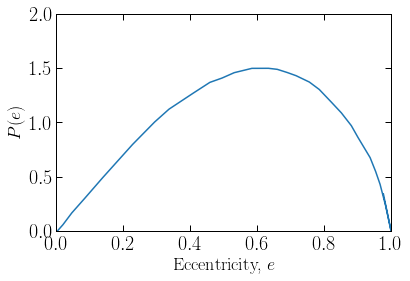

In [5]:
# First lets load our eccentricity distribution
elist_loaded, P_e_loaded = np.loadtxt('../data/eccentricity.txt', unpack=True, delimiter=',')
P_e = interp1d(elist_loaded, P_e_loaded, bounds_error=False, fill_value = 0.0)

plt.figure()
plt.plot(elist_loaded, P_e_loaded)

plt.xlabel("Eccentricity, $e$")
plt.ylabel(r"$P(e)$")
plt.xlim(0, 1)
plt.ylim(0, 2)
plt.savefig("../plots/Pe.pdf", bbox_inches='tight')
plt.show()

In [6]:
def drdt(r, a, e, M):
    
    eps = -(G_N*M)/(2*a)
    h = np.sqrt(G_N*M*a*(1-e**2))
    
    return (2*eps - h**2/r**2 + 2*G_N*M/r)**0.5

def dPdr(r, a, e, M=1):
    r_min = a*(1-e)
    r_max = a*(1+e)
    T_orb = (2*np.pi)*np.sqrt(a**3/(G_N*M))
    return 2*(T_orb*drdt(r, a, e, M))**-1

In [7]:
def add_curve(a, e, M=1, label=None):
    print("   Calculating for (a, e) = (%f, %f)"% (a, e))
    r_min = a*(1-e)
    r_max = a*(1+e)
    
    delta = 1e-5
    
    r1 = np.geomspace(r_min*(1+delta), a, 10000)
    r2 = r_max*(1 - np.geomspace(delta, 0.99*a/r_max, 10000))
    r_list = np.sort(np.append(r1, r2))
    
    P_list = dPdr(r_list, a, e, M)
    
    plt.plot(r_list, P_list,label=label)

   Calculating for (a, e) = (1.000000, 0.100000)
   Calculating for (a, e) = (1.000000, 0.500000)
   Calculating for (a, e) = (1.000000, 0.900000)


/Users/bradkav/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in sqrt
  


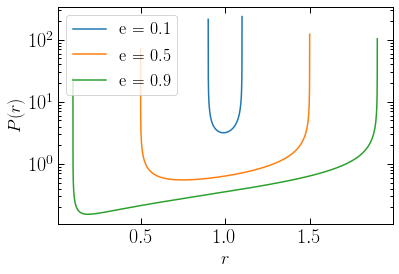

In [8]:
plt.figure()

add_curve(1, 0.1, label="e = 0.1")
add_curve(1, 0.5, label="e = 0.5")
add_curve(1, 0.9, label="e = 0.9")

plt.legend()
plt.gca().set_yscale('log')

plt.xlabel(r"$r$")
plt.ylabel(r"$P(r)$")

plt.show()

In [9]:
r_bins = np.linspace(0, 2, 21)

from itertools import cycle
lines = ["-","--","-."]
linecycler = cycle(lines)


def plot_bins(a, e, M=1, label=None):
    r_min = a*(1-e)
    r_max = a*(1+e)
    print("   r = [", r_min, ", ", r_max, "]")
    
    def dPdr_corrected(r):
        if not (r_min < r < r_max):
            return 0
        else: 
            return dPdr(r, a, e, M=M)
    
    frac = np.zeros(len(r_bins)-1)
    for i in range(len(r_bins)-1):
        frac[i] = quad(dPdr_corrected, r_bins[i], r_bins[i+1], epsrel=1e-6)[0]
                    
            
    print("   normalisation:", np.sum(frac))
    plt.step(r_bins[:-1], frac, where='mid', label=label, ls=next(linecycler))

   r = [ 0.9 ,  1.1 ]
   normalisation: 0.9999999999378593
   r = [ 0.5 ,  1.5 ]
   normalisation: 1.0000000000002633
   r = [ 0.09999999999999998 ,  1.9 ]
   normalisation: 1.000000000002526


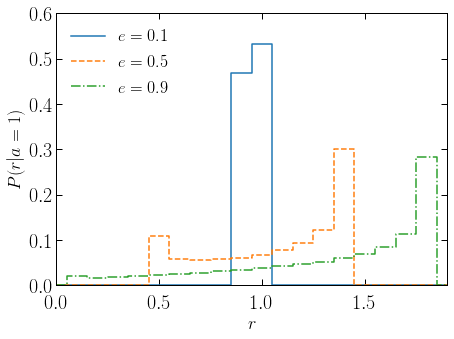

In [12]:
fig, ax = plt.subplots(figsize=(7,5))

plot_bins(1, 0.1, label="$e = 0.1$")
plot_bins(1, 0.5, label="$e = 0.5$")
plot_bins(1, 0.9, label="$e = 0.9$")

plt.legend(frameon=False, loc='upper left')

plt.xlabel(r"$r$")
plt.ylabel(r"$P(r|a=1)$")

ax.tick_params(axis='x', pad=9)
plt.xlim(0.0,1.9)
plt.ylim(0.0,0.6)

plt.savefig("../plots/OrbitalRadius.pdf", bbox_inches='tight')
plt.show()

#### Calculating the distribution P(r) for a given distribution of eccentricities

Let's now do everything in terms of $x = r/a$:

In [13]:
def Px_given_e(x, e):
    arg = 2/x - (1-e**2)/x**2 - 1
    res = np.zeros_like(arg)
    res[arg > 0] = (1/np.pi)*(arg[arg>0])**(-1/2)
    return res

In [14]:
def Px(x):
    e_list = np.linspace(1e-5, 0.9999, 1000)
    res = np.array([np.trapz(P_e(e_list)*Px_given_e(xi, e_list), e_list) for xi in x])
    return res

In [15]:
xlist = np.linspace(1e-5, 1.999, 1000)
Pxlist = Px(xlist)
P_x_interp = interp1d(xlist, Pxlist, bounds_error=False, fill_value = 0.0)

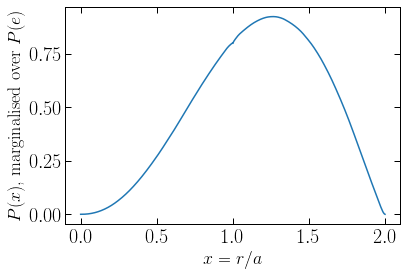

In [16]:
plt.figure()
plt.plot(xlist, Pxlist)

plt.xlabel(r"$x = r/a$")
plt.ylabel(r"$P(x)$, marginalised over $P(e)$")

plt.show()

In [17]:
print("Most likely value of x:", xlist[np.argmax(Pxlist)])
print("Mean value of x:", np.trapz(Pxlist*xlist, xlist))

Most likely value of x: 1.2626353153153154
Mean value of x: 1.1499688281089828


$$ P(r) = \int P(r | a) P(a) \,\mathrm{d}a = \int P(x = r/a) \frac{1}{a}P(a)\,\mathrm{d}a$$

In [18]:
rho0 =  1.4e7*1e-9 # Msun*pc^-3, see Table 1 in 1304.5127
r_s = 16.1e3 # pc

def rhoNFW(r):
    s = r/r_s
    return rho0/(s*(1+s)**2)

def Pr_NFW(r):
    return 4*np.pi*r**2*rhoNFW(r)

In [19]:
Px_interp = interp1d(xlist, Pxlist, fill_value= 0.0, bounds_error=False)

In [20]:
def P_r(r):
    a_min = r/2
    a_max = 100e3
    a_list = np.geomspace(a_min, a_max, 1000)
    x_list = r/a_list
    P_a = 4*np.pi*a_list**2*rhoNFW(a_list)
    integ = Px_interp(x_list)*P_a/a_list
    return np.trapz(integ, a_list)

In [21]:
r_list = np.geomspace(1, 100e3)
Pr_list = np.array([P_r(r) for r in r_list])
Pr_interp = interp1d(r_list, Pr_list, bounds_error=False, fill_value = 0.0)

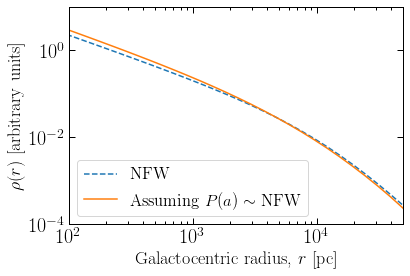

In [22]:
plt.figure()

plt.loglog(r_list, Pr_NFW(r_list)/(4*np.pi*r_list**2), '--',label='NFW')
plt.loglog(r_list, Pr_list/(4*np.pi*r_list**2), label='Assuming $P(a)\sim$ NFW')

plt.legend(loc='lower left')
plt.xlabel("Galactocentric radius, $r$ [pc]")
plt.ylabel(r"$\rho(r)$ [arbitrary units]")

plt.xlim(1e-1*1e3, 50e3)
plt.ylim(1e-4, 10)

plt.show()

## Now lets calculate the orbital positions of objects in eccentric orbits

We follow https://www.averylaird.com/2015/06/19/describing-elliptical-orbits-programmatically/ 

In [23]:
def calc_M(t, T):
    """
    M = mean anomaly
    """
    return (2 * np.pi * t) / T

def calc_E(M, e):
    """
    M = mean anomaly
    E = eccentric anomaly
    e = eccentricity
    """
    m = lambda E: M - E + (e * np.sin(E))
    Elist = np.linspace(0,2*np.pi)
    return brentq(m, 0, 2*np.pi)

@np.vectorize
def calc_theta(t, T, e):
    """
    (1 - e)tan^2(theta/2) = (1 + e)tan^2(E/2)
    e = eccentricity
    theta = true anomaly
    E = eccentric anomaly
    """
    M = calc_M(t, T)
    E = calc_E(M, e)
    theta_func = lambda theta: (1 - e) * np.tan(theta/2)**2 - (1 + e) * np.tan(E/2)**2
    theta = brentq(theta_func, 0, np.pi)
    
    if t < T/2:
        return theta
    else:
        return 2*(np.pi - theta) + theta

@np.vectorize
def calc_r(t, T, a, e):
    """
    a = semi-major axis
    r = a(1 - ecosE)
    """
    M = calc_M(t, T)
    E = calc_E(M, e)
    return a * (1 - (e * np.cos(E)))

In [24]:
def calc_orbit(M, a, e):
    T_orb = (2*np.pi)*np.sqrt(a**3/(G_N*M))
    t_list = np.linspace(0,T_orb,10000)
    r_list = calc_r(t_list, T_orb, a, e)
    theta_list = calc_theta(t_list, T_orb, e)
    return r_list, theta_list

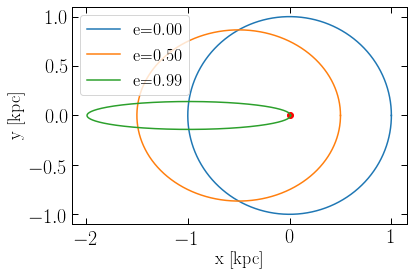

In [25]:
M = 1 
a = 1

plt.figure()

e_list = [0.0,0.5,0.99]
for e in e_list:
    
    r, theta = calc_orbit(M, a, e)
    x = r*np.cos(theta)
    y = r*np.sin(theta)
    plt.plot(x, y, label='e=%.2f'%e)

plt.scatter(0,0,color='r')
plt.legend(loc='upper left')
plt.xlabel("x [kpc]")
plt.ylabel(r"y [kpc]")

plt.show()

In [26]:
def P_ae_given_r(r, a, e):
    return (1/a)*Px_given_e(r/a, e)*P_e(e)*Pr_NFW(a)/Pr_interp(r)

In [27]:
from matplotlib import ticker, cm

In [28]:
alist1 = np.geomspace(1, 100e4, 100000)
elist1 = np.linspace(0, 1, 100)

a_grid, e_grid = np.meshgrid(alist1, elist1)

P_grid = P_ae_given_r(8e3, a_grid, e_grid)

/Users/bradkav/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: Log scale: values of z <= 0 have been masked
  import sys


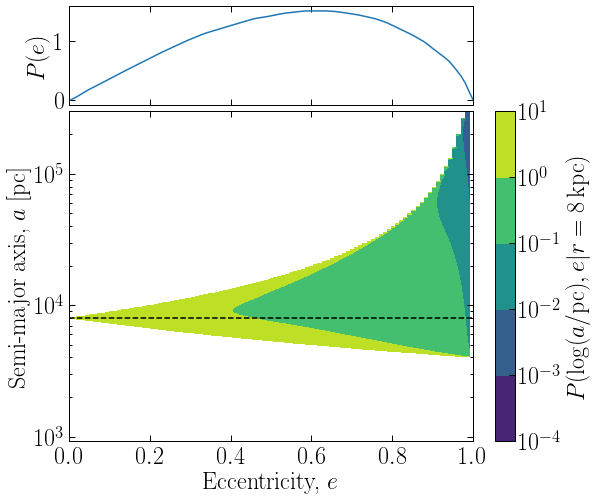

In [29]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
rc('font', size=24)

fig = plt.figure(figsize=(8,8))

ax0 = plt.subplot(111)
CS = ax0.contourf(e_grid, a_grid, a_grid*P_grid, locator=ticker.LogLocator(), levels=np.geomspace(1e-4, 1e1, 6))
ax0.set_yscale('log')
ax0.set_ylim(9.2e2, 3e5)

ax0.set_yticks([1e3, 1e4, 1e5])
# ax0.set_xticklabels([])
ax0.set_ylabel(r"Semi-major axis, $a$ [pc]", fontsize=24)
ax0.axhline(8e3, color='k', linestyle='--')
ax0.set_xlabel(r"Eccentricity, $e$", fontsize=24)

divider = make_axes_locatable(ax0)
ax1 = divider.append_axes("top", size="30%", pad=0.08)
cax = divider.append_axes("right", size="5%", pad=0.3)
cb = plt.colorbar(CS, ax=ax0, cax=cax )
cb.ax.set_ylabel(r'$P(\log(a/\mathrm{pc}), e | r = 8 \,\mathrm{kpc})$', fontsize=24)


ax1.plot(elist1, P_e(elist1))

ax1.set_xlim(0, 1)
ax1.set_xticklabels([])
ax1.set_ylabel(r"$P(e)$", fontsize=24)

plt.savefig("../plots/P_loga_e_given_r.pdf", bbox_inches='tight')
plt.show()